# Jan 26th, 2022 (cleaner figs, SE bug)

**Motivation**: Many figure functions. Encountered a possible bug in individual bootstrap.  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


from scipy.ndimage import gaussian_filter


def show_h(proj_h, proj_hr, idx: int = 0, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(1, 4, (10., 2), gridspec_kw={'width_ratios': [1.8, 1, 1, 1.8]})

    x2plt = proj_h['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()
    

def plot_cartography(
    df: pd.DataFrame,
    palette: Dict[str, str],
    xlim: Tuple[float, float] = None,
    ylim: Tuple[float, float] = None,
    grid: bool = True,
    display: bool = True,
    leg_size: float = 14,
    size: float = 7,
    scatter_kws: dict = None,
    density_kws: dict = None,
    median_kws: dict = None, ):
    
    scatter_kws = scatter_kws if scatter_kws else {
        's': 120,
        'alpha': 0.9,
        'edgecolor': 'dimgrey',
    }
    density_kws = density_kws if density_kws else {
        'lw': 2,
        'fill': True,
        'alpha': 0.5,
    }
    median_kws = median_kws if median_kws else {
        'lw': 2,
        'ls': '--',
        'zorder': 0,
        'alpha': 1.0,
        'c': sns.color_palette('deep')[7],
    }
    
    jg = sns.JointGrid(
        data=df,
        x='entropy',
        y='degree',
        hue='oc_idx',
        size=size,
        palette=palette,
        xlim=xlim,
        ylim=ylim,
        space=0.0,
    )
    # joint: scatter
    jg.plot_joint(
        sns.scatterplot,
        hue='oc_idx',
        **scatter_kws,
    )
    # margnials: density
    jg.plot_marginals(
        sns.kdeplot,
        **density_kws,
    )
    # medians
    for name in ['entropy', 'degree']:
        x = df[name].median()
        lbl = f"median {name}: {x:.2f}"
        if name == 'entropy':
            jg.ax_joint.axvline(x, label=lbl, **median_kws)
        else:
            jg.ax_joint.axhline(x, label=lbl, **median_kws)
    # legend
    jg.ax_joint.legend(loc='upper left', prop={'size': leg_size})
    leg = leg = jg.ax_joint.get_legend()
    if leg is not None:
        plt.setp(leg, bbox_to_anchor=(1.3, 1.0))
    
    if grid:
        jg.ax_joint.grid()
    
    if display:
        plt.show()
    else:
        plt.close()
    return jg


def plot_swarm(
        df: pd.DataFrame,
        palette: dict,
        variable: str = 'entropy',
        display: bool = True,
        **kwargs, ):
    defaults = {
        'sensory_idxs': [2, 3],
        'kind': 'swarm',
        'aspect': 1.2,
        's': 12,
        'x_fontsize': 15,
        'title_fontsize': 15,
        'xtick_labelsize': 13,
        'ytick_labelsize': 14,
    }
    for k, v in defaults.items():
        if k not in kwargs:
            kwargs[k] = v

    median = df[variable].median()
    sns.set_theme(style='ticks')
    fg = sns.catplot(
        x=variable,
        y='tag',
        data=df,
        hue='oc_idx',
        col='oc_type',
        order=sorted(df['tag'].unique()),
        palette=palette,
        kind=kwargs['kind'],
        aspect=kwargs['aspect'],
        s=kwargs['s'],
    )
    for ax in fg.axes.ravel():
        ax.axvline(
            x=median,
            ls='--',
            lw=2,
            alpha=1.0,
            c=sns.color_palette('deep')[7],
            label=f"median {variable}: {median:.2f}",
            zorder=0,
        )
        ax.tick_params('x', labelsize=kwargs['xtick_labelsize'])
        ax.tick_params('y', labelsize=kwargs['ytick_labelsize'])
        ax.title.set_fontsize(kwargs['title_fontsize'])
        ax.set_xlabel(variable, fontsize=kwargs['x_fontsize'])
        ax.set_ylabel('')
        ax.grid(axis='y')

    if display:
        plt.show()
    else:
        plt.close()
    return fg

## Prepare

In [3]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [4]:
props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'perc': 'p20-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}

gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group(skip_align=False)
gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group(skip_align=False)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

## Group

### Memberships

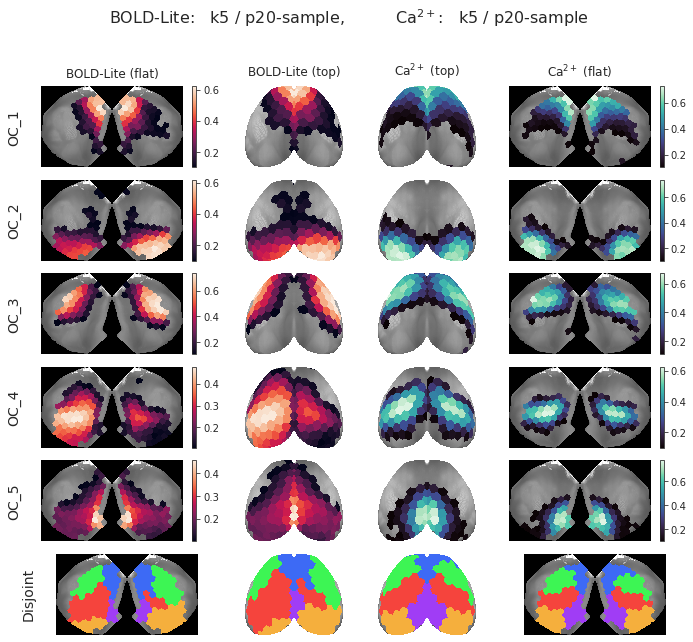

In [5]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

### Proportions

In [7]:
# Load SciPy boot
boot_bca = 'boot-BCa_group_1.0e+03_(2022_01_26).npy'
boot_bca = np.load(pjoin(tmp_dir, boot_bca), allow_pickle=True)
boot_bca = boot_bca.item()

# Load full boot
boot_gam = 'boot-GAM_group_1.0e+03_(2022_01_26).npy'
boot_gam = np.load(pjoin(tmp_dir, boot_gam), allow_pickle=True)
boot_gam = boot_gam.item()

# Prepare gam booted
_stat = mk_statistic_fn(gr_bold.bins, est_seed=None)

output_booted_ca = _stat(boot_gam['ca2'])
output_booted_bold = _stat(boot_gam['bold-lite'])
boot_gam['ca2'].shape, output_booted_ca['cut'].shape, output_booted_ca['cut_avg'].shape

((1000, 10, 3, 4, 5, 174), (1000, 10, 5, 4), (1000, 5, 4))

In [23]:
gr_ca.anim_cut.std(0, ddof=1) / np.sqrt(10)

array([[2.43730501, 0.99117844, 2.07657219, 2.03913143],
       [1.75769787, 1.60623069, 1.73644921, 3.24905565],
       [2.393746  , 1.50586871, 1.18249995, 2.79260771],
       [1.42274548, 1.06888679, 1.67237912, 1.02185087],
       [2.76135304, 1.26142689, 1.34429134, 4.23653593]])

In [24]:
boot_bca['ca2']['se']

array([[3.34299665, 1.53722588, 2.39201063, 3.18988577],
       [2.25049429, 1.75223923, 2.40392498, 3.82502352],
       [3.00903826, 2.12449068, 1.84653656, 3.38038528],
       [2.10925804, 1.60947389, 2.10703868, 1.27337126],
       [2.93063614, 1.42649219, 1.72244017, 4.44528582]])

In [25]:
output_booted_ca['cut_avg'].std(0, ddof=1)

array([[3.31429605, 1.51351319, 2.40832285, 3.27254895],
       [2.26518967, 1.76942482, 2.28384568, 3.63173335],
       [2.88452489, 1.98963098, 1.74505909, 3.12958875],
       [2.05131701, 1.62155508, 2.01174469, 1.26062329],
       [2.89172646, 1.50390603, 1.79898996, 4.49764132]])

[<matplotlib.lines.Line2D object at 0x7f86fc5be820>]

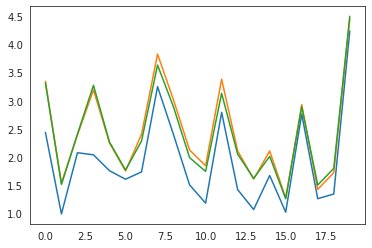

In [28]:
plt.plot((gr_ca.anim_cut.std(0, ddof=1) / np.sqrt(10)).ravel())
plt.plot(boot_bca['ca2']['se'].ravel())
plt.plot(output_booted_ca['cut_avg'].std(0, ddof=1).ravel())

In [14]:
delta = (
    boot_bca['ca2']['se'] - output_booted_ca['cut_avg'].std(0, ddof=1)
) / output_booted_ca['cut_avg'].std(0)
np.round(delta * 100, 1)

array([[ 0.9,  1.6, -0.7, -2.5],
       [-0.6, -1. ,  5.3,  5.3],
       [ 4.3,  6.8,  5.8,  8. ],
       [ 2.8, -0.7,  4.7,  1. ],
       [ 1.3, -5.2, -4.3, -1.2]])

In [15]:
boot_bca['ca2']['se'].shape

(5, 4)

In [11]:
df_boot_bold = gr_bold.mk_boot_df(boot_bca)
df_boot_ca = gr_ca.mk_boot_df(boot_bca)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig-1_ca2_(2022_01_26).pdf

done.

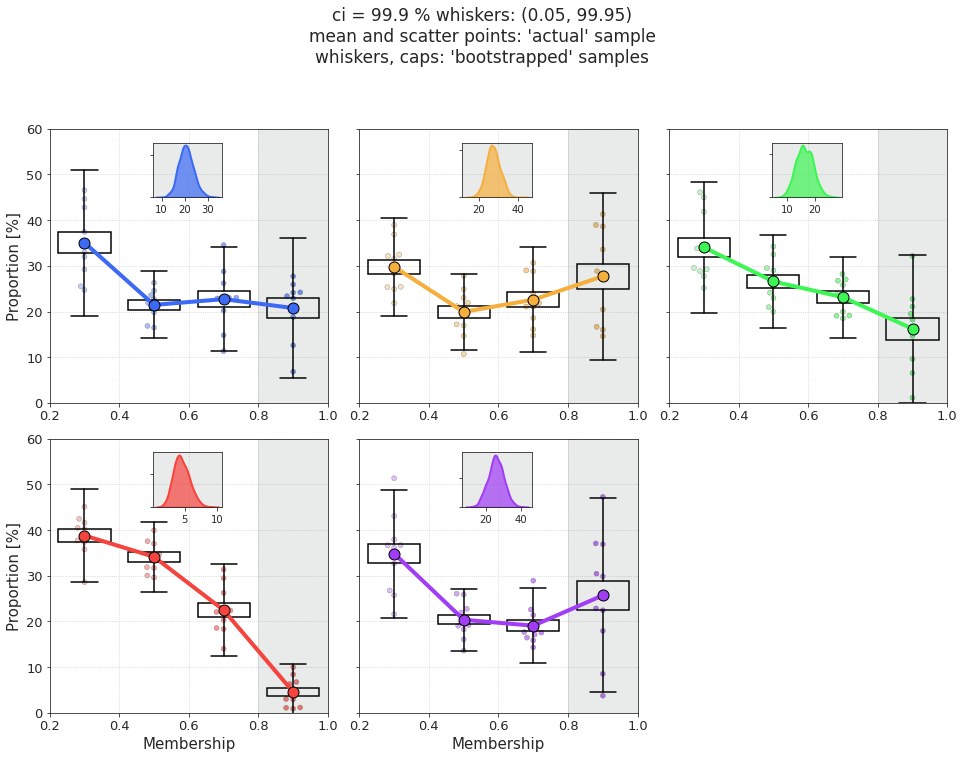

In [12]:
figs, sups, axes, axes_inset = plot_proportions(
    df=df_boot_ca,
    inset_kind='kde',
    inset_data=output_booted_ca['cut_avg'][..., -1].T,
    save_file=pjoin(tmp_dir, f"Fig-1_ca2_{now()}.pdf"),
)
figs[-1]

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig-1_bold-lite_(2022_01_26).pdf

done.

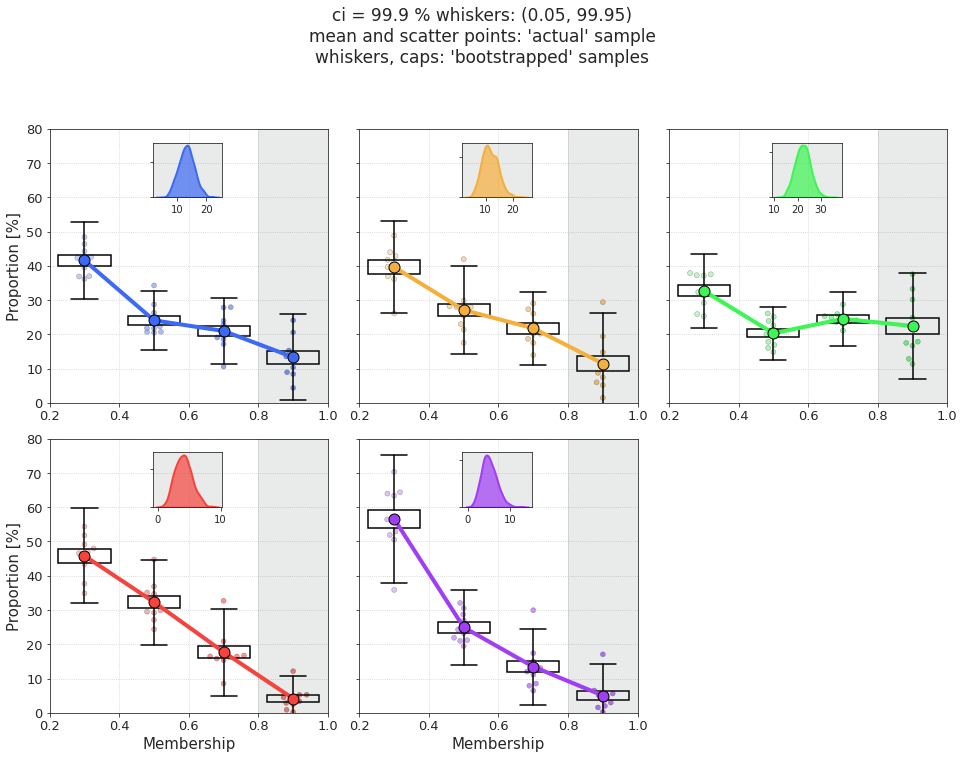

In [13]:
figs, sups, axes, axes_inset = plot_proportions(
    df=df_boot_bold,
    inset_kind='kde',
    inset_data=output_booted_bold['cut_avg'][..., -1].T,
    save_file=pjoin(tmp_dir, f"Fig-1_bold-lite_{now()}.pdf"),
)
figs[-1]

### Percent nodes with mixed membership

In [14]:
# HIDE CODE

theta_all = collections.defaultdict(dict)
dlist1, dlist2 = [], []
for k in range(2, 9):
    props = props_base.copy()
    props['num_k'] = k

    props_ca = {'perc': 'p20-sample', **props}
    props_bold = {'perc': 'p20-sample', **props}
    
    # Group results
    _gr_ca = Group(
        mode='ca2',
        centroids_from='runs',
        **props_ca,
    ).fit_group(skip_align=False)
    _gr_bold = Group(
        mode='bold-lite',
        centroids_from='runs',
        **props_bold,
    ).fit_group(skip_align=False)

    maxmem = {
        'ca2': _gr_ca.run_maxmem.ravel(),
        'bold-lite': _gr_bold.run_maxmem.ravel(),
    }
    for mode, x in maxmem.items():
        dlist1.append({
            'maxmem': x,
            'K': [k] * len(x),
            'mode': [mode] * len(x),
        })

    theta = {
        'ca2': bn.nanmean(bn.nanmean(_gr_ca.run_theta, -1), -1),
        'bold-lite': bn.nanmean(bn.nanmean(_gr_bold.run_theta, -1), -1),
    }
    for mode, x in theta.items():
        dlist2.append({
            'theta': x,
            'K': [k] * len(x),
            'mode': [mode] * len(x),
            'animal': range(1, len(x) + 1),
        })
    theta_all[k] = theta
df1 = pd.DataFrame(merge_dicts(dlist1))
df2 = pd.DataFrame(merge_dicts(dlist2))

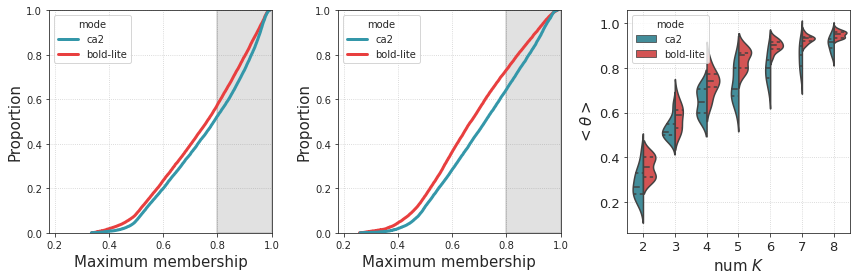

In [15]:
# HIDE CODE


fig, axes = create_figure(1, 3, (12, 4))

for ax, k in zip(axes[:2], [3, 4, 5]):
    ax.axvspan(
        xmin=0.8,
        xmax=1.0,
        lw=2,
        alpha=0.2,
        color='dimgrey',
        label='Disjoint zone',
    )
    sns.ecdfplot(
        data=df1.loc[df1['K'] == k],
        x='maxmem',
        hue='mode',
        palette=pal,
        lw=3,
        ax=ax,
    )
    ax.set_ylabel(r'Proportion', fontsize=15)
    ax.set_xlabel(r'Maximum membership', fontsize=15)
    ax.set_xlim(0.18, 1.0)
    ax.grid()

ax = axes[-1]
sns.violinplot(
    data=df2,
    x='K',
    y='theta',
    hue='mode',
    inner="quartile",
    palette=pal,
    split=True,
    ax=ax,
)
ax.set_ylabel(r'$<\theta>$', fontsize=15)
ax.set_xlabel(r'num $K$', fontsize=15)
ax.tick_params('both', labelsize=13)
ax.grid()

plt.show()

### Ca vs BOLD similarity

#### Plots for k in [2, ..., 8]

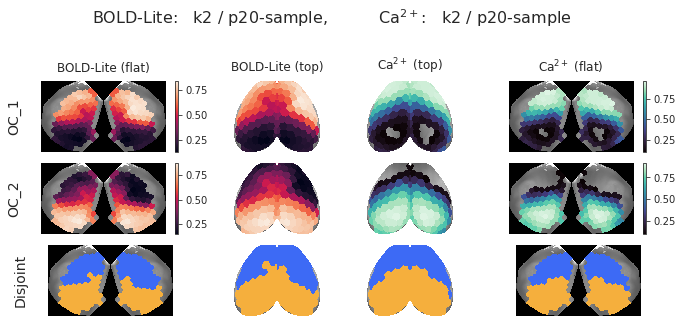

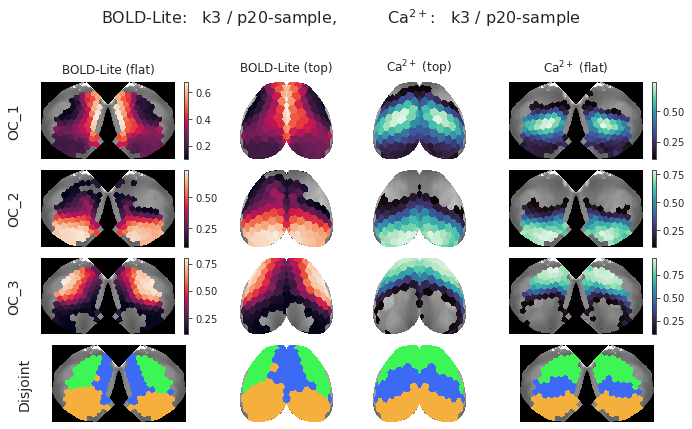

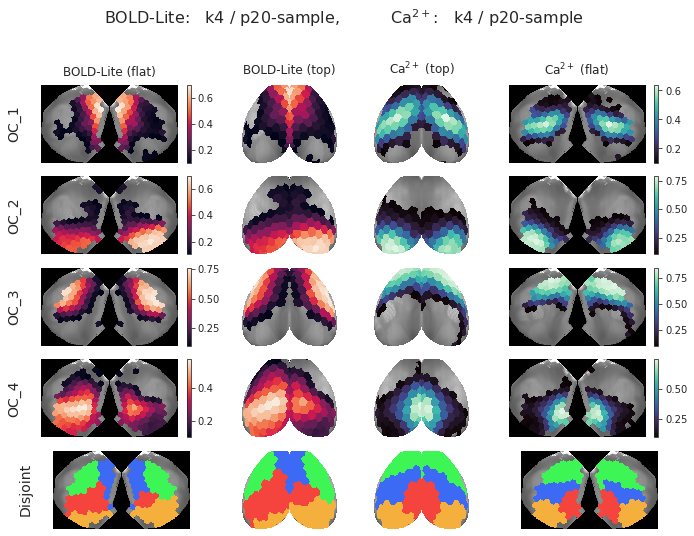

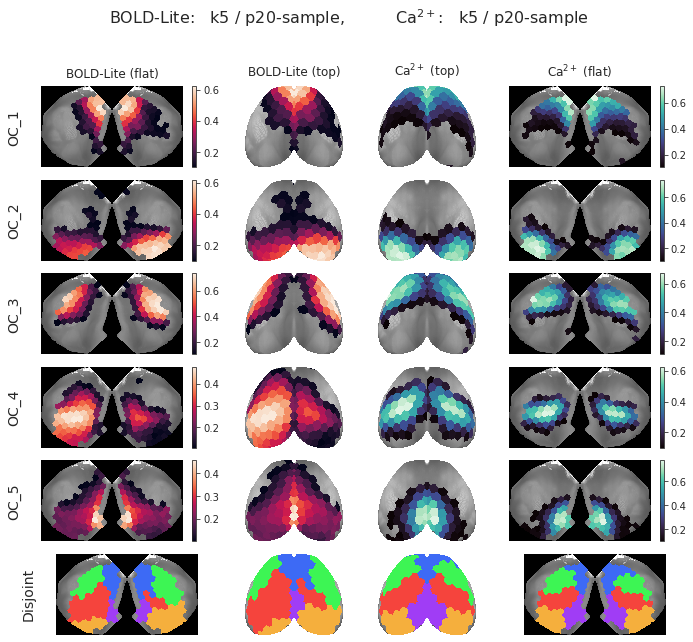

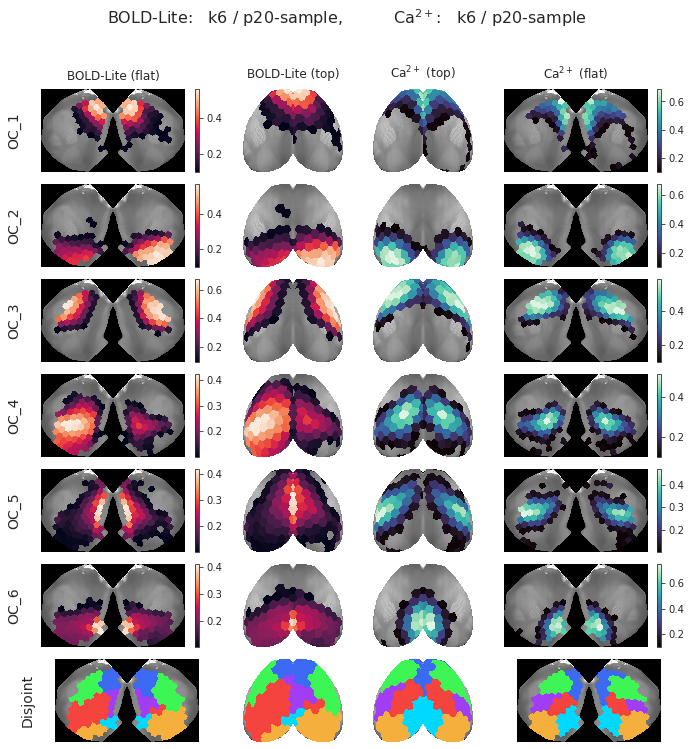

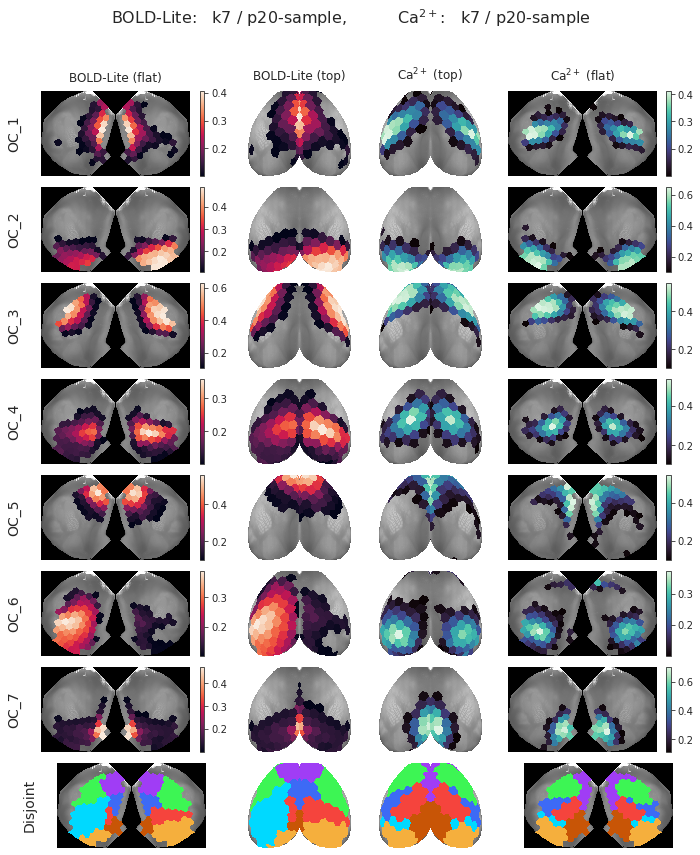

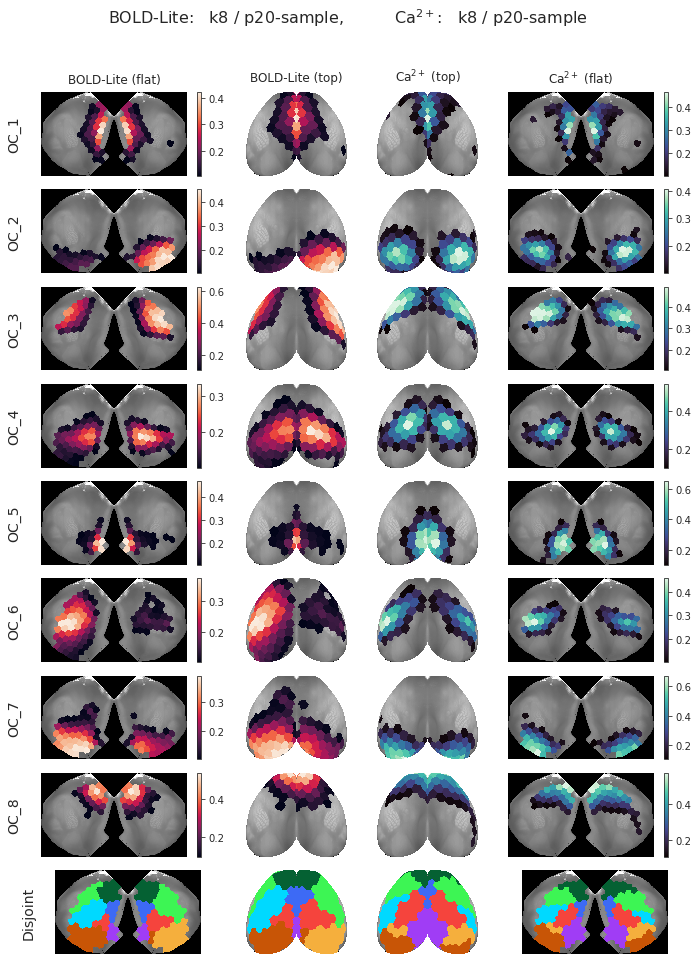

In [16]:
# HIDE CODE


for k in range(2, 9):
    props = props_base.copy()
    props['num_k'] = k

    props_ca = {'perc': 'p20-sample', **props}
    props_bold = {'perc': 'p20-sample', **props}

    # Group results
    _gr_ca = Group(
        mode='ca2',
        centroids_from='runs',
        **props_ca,
    ).fit_group(skip_align=False)
    _gr_bold = Group(
        mode='bold-lite',
        centroids_from='runs',
        **props_bold,
    ).fit_group(skip_align=False)

    sim = dist2sim(sp_dist.cdist(
        XA=_gr_bold.grp_pi,
        XB=_gr_ca.grp_pi,
        metric='cosine',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())

    _gr_bold.pi = _gr_bold.grp_pi
    _gr_ca.pi = _gr_ca.grp_pi[ids]

    proj_bold = _gr_bold.project_vec()
    proj_ca = _gr_ca.project_vec()
    
    fig, _ = _gr_ca.show(
        proj_bold, proj_ca,
        labels=('BOLD-Lite', r'Ca$^{2+}$'),
        cmaps=('rocket', 'mako'),
        display=False,
    )
    sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
    sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
    sup = fig.suptitle(sup, fontsize=16, y=1.02)

    display(fig)

#### Scores (cosine + hamming)

In [18]:
# HIDE CODE


scores_cos, scores_ham = {}, {}
for k in range(2, 9):
    props = props_base.copy()
    props['num_k'] = k

    props_ca = {'perc': 'p20-sample', **props}
    props_bold = {'perc': 'p20-sample', **props}

    # Group results
    _gr_ca = Group(
        mode='ca2',
        centroids_from='runs',
        **props_ca,
    ).fit_group(skip_align=False)
    _gr_bold = Group(
        mode='bold-lite',
        centroids_from='runs',
        **props_bold,
    ).fit_group(skip_align=False)

    sim = dist2sim(sp_dist.cdist(
        XA=_gr_bold.grp_pi,
        XB=_gr_ca.grp_pi,
        metric='cosine',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())
    scores_cos[k] = sim[:, ids]

    _gr_bold.pi = _gr_bold.grp_pi
    _gr_ca.pi = _gr_ca.grp_pi[ids]
    partition_bold = _gr_bold.get_disjoint_community(to_vec=True)
    partition_ca = _gr_ca.get_disjoint_community(to_vec=True)
    
    ham = np.zeros_like(sim)
    for i, j in itertools.combinations(range(1, 1 + k), 2):
        ham[i - 1, j - 1] = sp_dist.hamming(
            partition_bold == i, partition_ca == j)
    ham = ham + ham.T
    for i in range(1, 1 + k):
        ham[i - 1, i - 1] = sp_dist.hamming(
            partition_bold == i, partition_ca == i)
    scores_ham[k] = 1 - ham

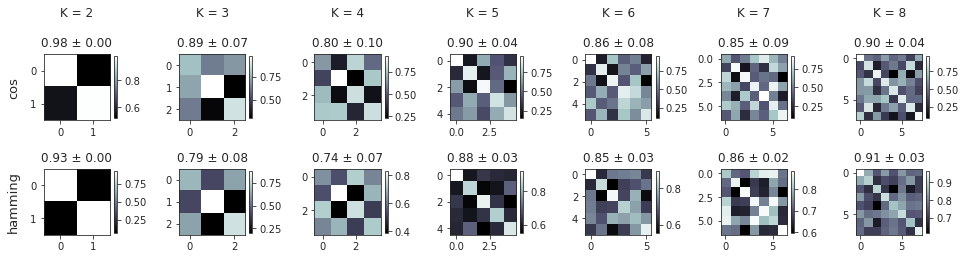

In [19]:
# HIDE CODE


fig, axes = create_figure(2, 7, (13.5, 3.75))

for i, (lbl, d) in enumerate({'cos': scores_cos, 'hamming': scores_ham}.items()):
    for ax, (k, s) in zip(axes[i].flat, d.items()):
        im = ax.imshow(s, cmap='bone')#, vmin=0, vmax=1)
        plt.colorbar(im, ax=ax, shrink=0.7)

        s_diag = np.diag(s)
        
        if i == 0:
            msg = f"K = {k}\n\n"
        else:
            msg = ''
        msg += f"{s_diag.mean():0.2f} ± {s_diag.std():0.2f}"
        ax.set_title(msg, fontsize=12, y=1.02)
        
        if k == list(scores_cos)[0]:
            ax.set_ylabel(lbl, fontsize=13, labelpad=10)
        # ax.invert_yaxis()

plt.show()

In [20]:
# HIDE CODE


dlist = []
for k, cos in scores_cos.items():
    dlist.append({
        'k': [k] * k,
        'label': ['cos'] * k,
        'score': np.diag(cos),
        'oc_idx': range(1, 1 + k),
    })
    dlist.append({
        'k': [k] * k,
        'label': ['ham'] * k,
        'score': np.diag(scores_ham[k]),
        'oc_idx': range(1, 1 + k),
    })
df_compare = pd.DataFrame(merge_dicts(dlist))

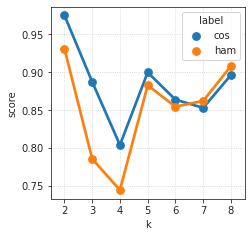

In [21]:
# HIDE CODE


fig, ax = create_figure(figsize=(3.6, 3.4))
sns.pointplot(
    data=df_compare,
    x='k',
    y='score',
    hue='label',
    ci=None,
    ax=ax,
)
ax.grid()

### Cartography

In [22]:
df_carto_ca = gr_ca.mk_cartography_df()
df_carto_bold = gr_bold.mk_cartography_df()
df_carto = pd.concat([df_carto_bold, df_carto_ca])

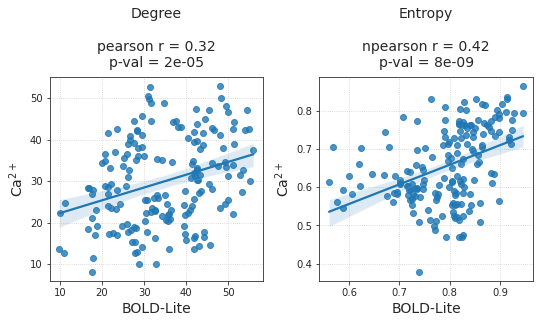

In [23]:
# HIDE CODE


fig, axes = create_figure(1, 2, (7.6, 4.6))

rho = sp_stats.pearsonr(df_carto_bold['degree'], df_carto_ca['degree'])
sns.regplot(
    x=df_carto_bold['degree'],
    y=df_carto_ca['degree'],
    ax=axes[0],
)
axes[0].set_ylabel(r'Ca$^{2+}$', fontsize=14)
axes[0].set_xlabel('BOLD-Lite', fontsize=14)
axes[0].set_title(f"Degree\n\npearson r = {rho[0]:0.2f}\np-val = {rho[1]:1.0e}", fontsize=14, y=1.02)
axes[0].grid()

rho = sp_stats.pearsonr(df_carto_bold['entropy'], df_carto_ca['entropy'])
sns.regplot(
    x=df_carto_bold['entropy'],
    y=df_carto_ca['entropy'],
    ax=axes[1],
)
axes[1].set_ylabel(r'Ca$^{2+}$', fontsize=14)
axes[1].set_xlabel('BOLD-Lite', fontsize=14)
axes[1].set_title(f"Entropy\n\nnpearson r = {rho[0]:0.2f}\np-val = {rho[1]:1.0e}", fontsize=14, y=1.02)
axes[1].grid()

plt.show()

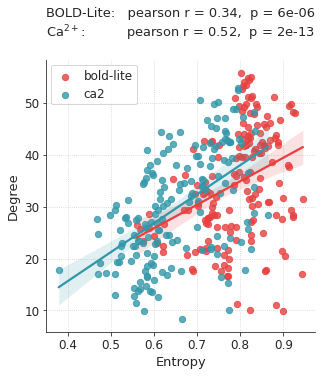

In [24]:
# HIDE CODE


sns.set_style('ticks')
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['grid.linestyle'] = ':'

g = sns.lmplot(
    data=df_carto,
    x='entropy',
    y='degree',
    hue='mode',
    palette=pal,
    legend_out=False,
    aspect=1,
    height=4.5,
    scatter_kws={'s': 40},
)
g.ax.tick_params(axis='both', labelsize=12)
g.ax.set_xlabel('Entropy', fontsize=13)
g.ax.set_ylabel('Degree', fontsize=13)
g.ax.grid()

leg = g.ax.get_legend()
for text in leg.get_texts():
    plt.setp(text, fontsize=12)
leg.set_title(None)
    # plt.setp(leg.get_title(), fontsize=14)
    
_df = df_carto.loc[df_carto['mode'] == 'bold-lite']
rho = sp_stats.pearsonr(_df['entropy'], _df['degree'])
msg = 'BOLD-Lite:   '
msg += f"pearson r = {rho[0]:0.2f},  p = {rho[1]:1.0e}\n"
_df = df_carto.loc[df_carto['mode'] == 'ca2']
rho = sp_stats.pearsonr(_df['entropy'], _df['degree'])
msg += r'Ca$^{2+}$:          '
msg += f"pearson r = {rho[0]:0.2f},  p = {rho[1]:1.0e}\n"
g.ax.set_title(msg, fontsize=13)
    
plt.show()

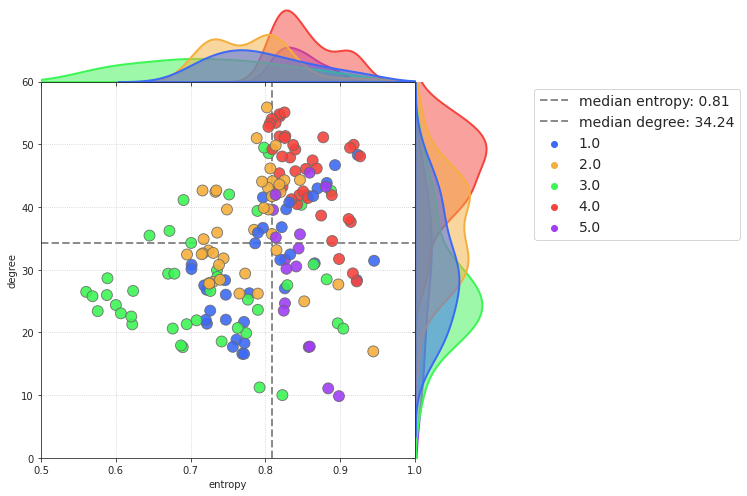

In [25]:
_ = plot_cartography(
    df=df_carto_bold,
    palette=gr_bold.colors,
    xlim=(0.5, 1.0),
    ylim=(0, 60),
)

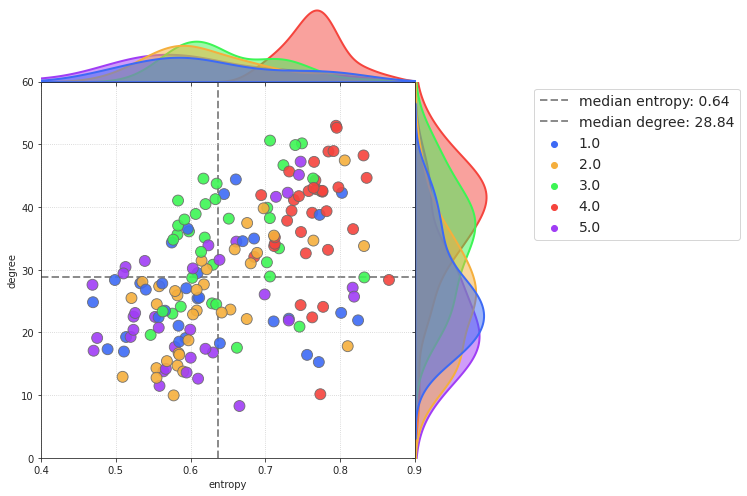

In [26]:
jg = plot_cartography(
    df=df_carto_ca,
    palette=gr_ca.colors,
    xlim=(0.4, 0.9),
    ylim=(0, 60),
)

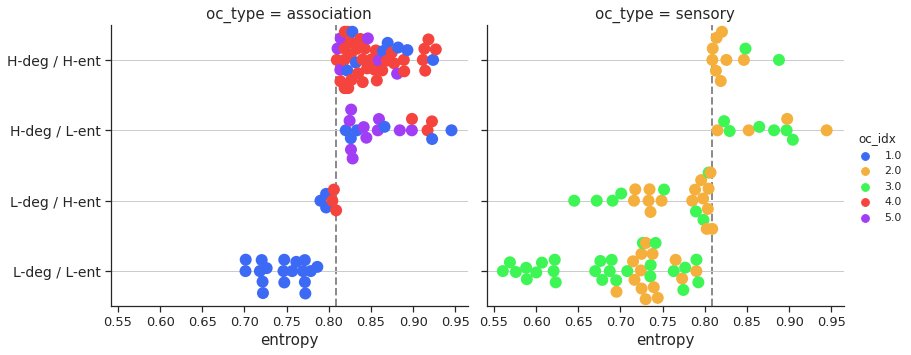

In [27]:
_ = plot_swarm(
    df=df_carto_bold,
    palette=gr_ca.colors,
)

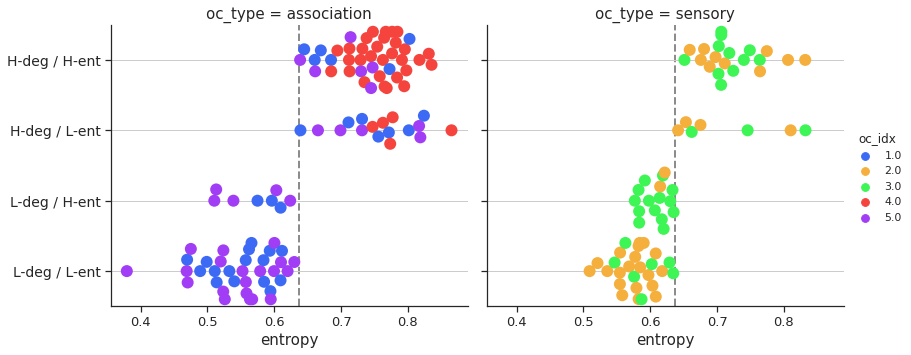

In [28]:
_ = plot_swarm(
    df=df_carto_ca,
    palette=gr_ca.colors,
)

## sub-SLC04

### Memberships

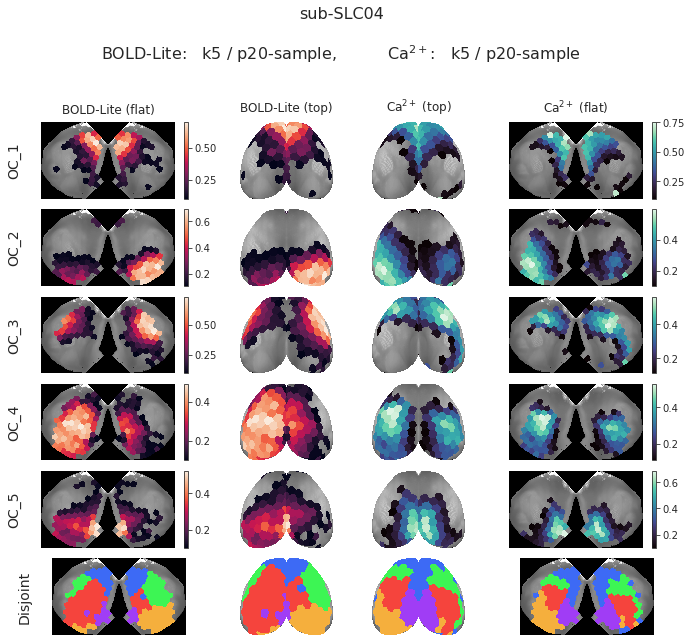

In [16]:
anim = 3
proj_bold = gr_bold.project_vec(gr_bold.anim_pi[anim])
proj_ca = gr_ca.project_vec(gr_ca.anim_pi[anim])

fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"{mice.get_key(anim + 1)}\n\n"
sup += f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [ ]:
fig, axes = create_figure(2, 5, (25, 8), 'all')
for ax, k in zip(axes[0].flat, range(5)):
    sns.kdeplot(output_booted_ca['cut_avg'][:, k, -1], label='group / cut_avg', ax=ax)
    sns.kdeplot(output_booted_ca['cut'][:, 8, k, -1], label='group / cut[8]', ax=ax)
    ax.legend()
    
for ax, k in zip(axes[1].flat, range(5)):
    sns.kdeplot(output_booted_ca['cut_avg'][:, k, -1], label='group / cut_avg', ax=ax)
    sns.kdeplot(output_booted_ca['cut'][:, 3, k, -1], label='group / cut[3]', ax=ax)
    ax.legend()

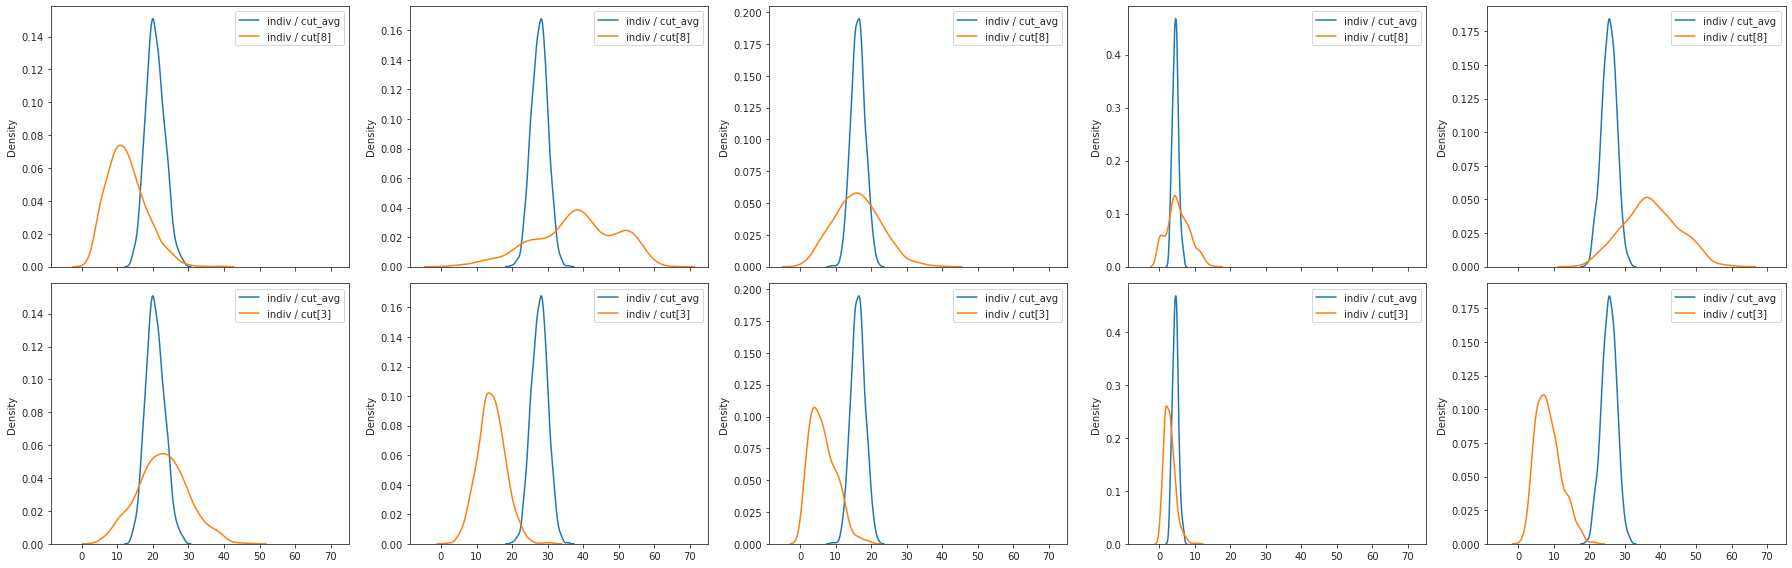

In [31]:
fig, axes = create_figure(2, 5, (25, 8), 'all')
for ax, k in zip(axes[0].flat, range(5)):
    sns.kdeplot(output_booted_ca['cut_avg'][:, k, -1], label='indiv / cut_avg', ax=ax)
    sns.kdeplot(output_booted_ca['cut'][:, 8, k, -1], label='indiv / cut[8]', ax=ax)
    ax.legend()
    
for ax, k in zip(axes[1].flat, range(5)):
    sns.kdeplot(output_booted_ca['cut_avg'][:, k, -1], label='indiv / cut_avg', ax=ax)
    sns.kdeplot(output_booted_ca['cut'][:, 3, k, -1], label='indiv / cut[3]', ax=ax)
    ax.legend()

<AxesSubplot:ylabel='Count'>

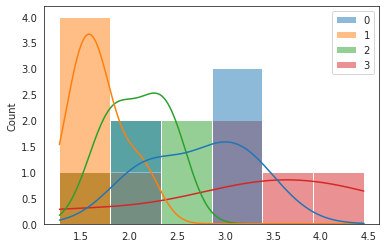

In [20]:
sns.histplot(boot_bca['ca2']['se'], kde=True)

In [17]:
# Load SciPy boot
boot_bca = 'boot-BCa_indiv_1.0e+03_(2022_01_26).npy'
boot_bca = np.load(pjoin(tmp_dir, boot_bca), allow_pickle=True)
boot_bca = boot_bca.item()

# Load full boot
boot_gam = 'boot-GAM_indiv_1.0e+03_(2022_01_26).npy'
boot_gam = np.load(pjoin(tmp_dir, boot_gam), allow_pickle=True)
boot_gam = boot_gam.item()

# Prepare gam booted
_stat = mk_statistic_fn(gr_bold.bins, est_seed=None)

output_booted_ca = _stat(boot_gam['ca2'])
output_booted_bold = _stat(boot_gam['bold-lite'])
boot_gam['ca2'].shape, output_booted_ca['cut'].shape, output_booted_bold['cut'].shape

((1000, 10, 3, 4, 5, 174), (1000, 10, 5, 4), (1000, 10, 5, 4))

<AxesSubplot:ylabel='Count'>

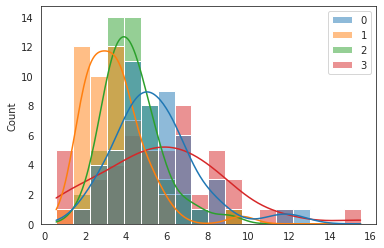

In [18]:
sns.histplot(boot_bca['ca2']['se'].reshape(50, 4), kde=True)

<AxesSubplot:ylabel='Count'>

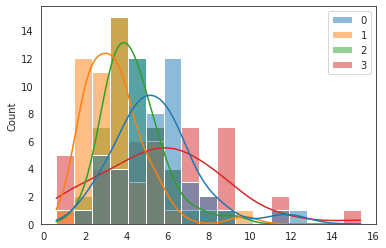

In [34]:
boot_gam['ca2'][:, anim, ...].shape

(1000, 3, 4, 5, 174)

In [31]:
gr_ca.run_gam[anim].shape

(3, 4, 500, 5, 174)

In [32]:
x = gr_ca.run_gam

In [33]:
{
    f"d{i}": d for i, d in
    enumerate(x.shape[:4])
}

{'d0': 10, 'd1': 3, 'd2': 4, 'd3': 500}

In [73]:
df_goes_int = df.loc[df['subject'] == anim]
_df = df_goes_int.loc[df_goes_int['oc_idx'] == 1]

In [74]:
selected_df = _df.loc[_df['interval'] == _df['interval'].unique()[3]]

In [75]:
selected_df

,subject,oc_idx,interval,color,se,mean
33,3,1,"(0.8, 1.0]",#3d6af5,7.328673,23.383766


In [78]:
real = np.nanmean(selected_df['mean'].values)
se = selected_df['se'].unique().item()
real, se

(23.38376563819142, 7.328672809306802)

In [35]:
output_booted_ca['cut'][:, anim, :, -1].shape

(1000, 5)

In [36]:
output_booted_ca['cut'][:, anim, :, -1].mean(0)

array([22.73191922, 14.24244596,  6.42917803,  2.90113147,  8.5064845 ])

In [37]:
output_booted_ca['cut'].std(0).shape

(10, 5, 4)

In [38]:
df = gr_ca.mk_boot_df(boot_bca['ca2']['se'])
df = df.loc[df['subject'] == anim]
df

,oc_idx,interval,subject,color,se,mean
2,1,"(0.2, 0.4]",3,#3d6af5,4.722640,34.778652
12,1,"(0.4, 0.6]",3,#3d6af5,5.141528,26.283051
22,1,"(0.6, 0.8]",3,#3d6af5,2.718245,14.808526
32,1,"(0.8, 1.0]",3,#3d6af5,5.039507,24.129772
42,2,"(0.2, 0.4]",3,#f5af3d,5.854203,36.887498
52,2,"(0.4, 0.6]",3,#f5af3d,3.798136,20.836133
62,2,"(0.6, 0.8]",3,#f5af3d,4.107602,21.833802
72,2,"(0.8, 1.0]",3,#f5af3d,5.650254,20.442567
82,3,"(0.2, 0.4]",3,#3df554,4.669112,29.553976
92,3,"(0.4, 0.6]",3,#3df554,2.041654,29.013087


/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig-1_ca2_sub-SLC04_(2022_01_26).pdf

done.

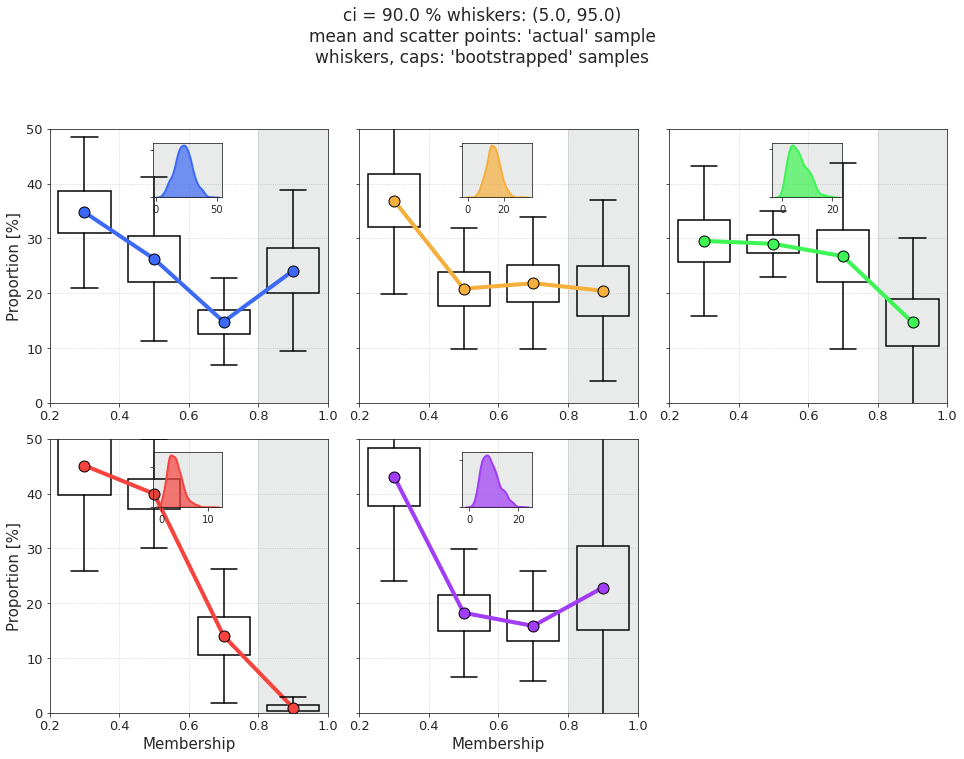

In [45]:
figs, sups, axes, axes_inset = plot_proportions(
    df=df,
    inset_data=output_booted_ca['cut'][:, anim, :, -1].T,
    save_file=pjoin(tmp_dir, f"Fig-1_ca2_{mice.get_key(anim + 1)}_{now()}.pdf"),
    ci=[0.90, 0.95, 0.99],
)
figs[0]

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig-1_bold_sub-SLC04_(2022_01_26).pdf

done.

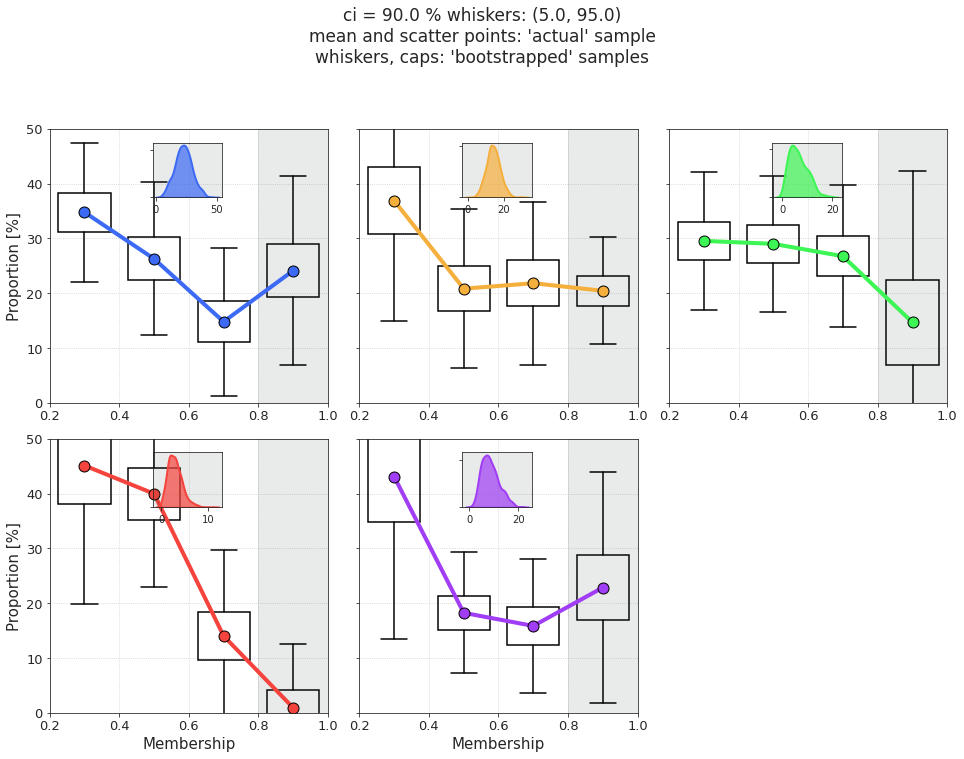

In [46]:
df = gr_ca.mk_boot_df(boot_bca['bold-lite']['se'])
df = df.loc[df['subject'] == anim]

figs, sups, axes, axes_inset = plot_proportions(
    df=df,
    inset_data=output_booted_ca['cut'][:, anim, :, -1].T,
    save_file=pjoin(tmp_dir, f"Fig-1_bold_{mice.get_key(anim + 1)}_{now()}.pdf"),
    ci=[0.90, 0.95, 0.99],
)
figs[0]

In [6]:
anim = 3

In [12]:
dims = {'d0': 3, 'd1': 4, 'd2': 500}
n_resamples = 1000
batch = 5

booted_correct = bootstrap(
    x=gr_ca.run_gam[anim],
    n_resamples=n_resamples,
    batch=batch,
    dims=dims,
    est=bn.nanmean,
    indiv=False,
)
booted_correct.shape

(1000, 3, 4, 5, 174)

In [10]:
boot_gam['ca2'][:, anim, ...].shape

(1000, 3, 4, 5, 174)

In [49]:
def fun(x):
    pi = pi_from_gam(x, axis_comm=-2, est_seed=None)
    k, n = pi.shape[-2:]
    cut, _ = cut_data(
        data=pi.reshape(-1, k, n),
        bins=gr_ca.bins,
        oc_only=True,
    )
    cut = cut.reshape((*pi.shape[:-2], k, -1))
    # print(cut.shape)
    return bn.nanmean(bn.nanmean(cut, 1), 1)

(1000, 3, 4, 5, 4)

(1000, 3, 4, 5, 4)

((1000, 5, 4), (1000, 5, 4))

In [50]:
a = fun(booted_correct)
b = fun(boot_gam['ca2'][:, anim, ...])
a.shape, b.shape

((1000, 5, 4), (1000, 5, 4))

<matplotlib.legend.Legend object at 0x7fc1cba78460>

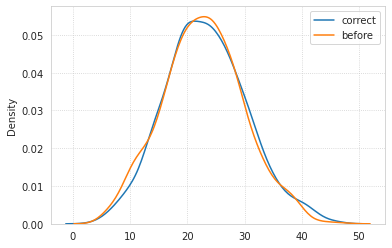

In [62]:
k = 0
sns.kdeplot(a[:, k, -1], label='correct')
sns.kdeplot(b[:, k, -1], label='before')
plt.legend()

In [68]:
a.std(0, ddof=1)

array([[6.52176539, 3.38360546, 2.69505269, 7.15972152],
       [4.73270559, 4.25306726, 3.10140875, 3.75743573],
       [6.6812239 , 3.66006873, 4.00347761, 3.58228238],
       [8.75520624, 6.18561207, 4.52592708, 1.5329821 ],
       [5.13219935, 2.52275133, 4.27411701, 3.68507354]])

In [64]:
b.std(0, ddof=1)

array([[6.46561173, 3.34237405, 2.65197686, 7.07391141],
       [5.00720984, 4.23046081, 3.02439959, 3.89119044],
       [6.96645499, 3.84376981, 4.28847156, 3.72252513],
       [8.9854982 , 6.42356849, 4.58238249, 1.56869676],
       [5.0251666 , 2.50481173, 4.22708164, 3.59137378]])

In [24]:
output_booted_ca['cut'][:, anim, ...].shape

(1000, 5, 4)

In [25]:
output_booted_ca['cut'][:, anim, ...].std(0, ddof=1)

array([[6.46561173, 3.34237405, 2.65197686, 7.07391141],
       [5.00720984, 4.23046081, 3.02439959, 3.89119044],
       [6.96645499, 3.84376981, 4.28847156, 3.72252513],
       [8.9854982 , 6.42356849, 4.58238249, 1.56869676],
       [5.0251666 , 2.50481173, 4.22708164, 3.59137378]])

In [26]:
boot_bca['ca2']['se'][anim]

array([[6.38490369, 3.31102532, 2.63044365, 7.18397028],
       [4.82858528, 4.31558037, 3.10796427, 3.91353889],
       [6.77562816, 3.68465719, 4.19383721, 3.71071817],
       [8.48288337, 6.2129196 , 4.27699961, 1.57595491],
       [5.11068556, 2.43614399, 4.35003748, 3.60379136]])

In [27]:
output_booted_bold['cut'][:, anim, ...].std(0, ddof=1)

array([[6.11241865, 3.77857917, 6.72395562, 5.11959545],
       [4.89209448, 4.60866368, 3.96843346, 7.79372434],
       [3.98358336, 2.43509772, 3.55499128, 4.60630367],
       [4.6858477 , 7.30559604, 5.08232111, 1.02951871],
       [8.38842345, 4.99453677, 5.46933499, 2.0803061 ]])

In [28]:
boot_bca['bold-lite']['se'][anim]

array([[5.93942267, 3.78786219, 6.80631751, 5.22446381],
       [5.01002842, 4.50041002, 4.03292917, 7.86968066],
       [4.17269906, 2.41793846, 3.63270894, 4.67217756],
       [4.50984894, 7.51539259, 5.1894582 , 1.04161032],
       [8.50952693, 5.15731784, 5.40611042, 2.08434378]])

<matplotlib.legend.Legend object at 0x7fc1cbfaf160>

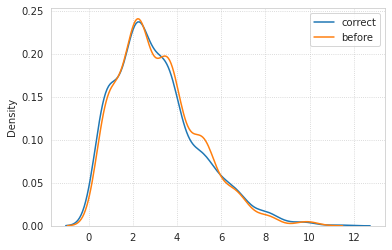

In [30]:
gr_ca.run_gam[anim].shape

(3, 4, 500, 5, 174)

In [35]:
pi = pi_from_gam(gr_ca.run_gam)
pi.shape

(10, 3, 4, 5, 174)

In [45]:
k, n = pi.shape[-2:]
cut, _ = cut_data(
    data=pi.reshape(-1, k, n),
    bins=gr_ca.bins,
    oc_only=True,
)
cut = cut.reshape((*pi.shape[:-2], k, -1))
# cut = bn.nanmean(bn.nanmean(cut, -3), -3)
cut.shape

(10, 3, 4, 5, 4)

In [47]:
x = cut[anim]
x.shape

(3, 4, 5, 4)

In [52]:
y = bn.nanmean(x, 1)
y

array([[[34.54090939, 16.12842812, 25.12936861, 24.20129389],
        [37.65255521, 30.93699108, 20.0379047 , 11.37254902],
        [45.61949856, 31.67646547, 18.6717779 ,  4.03225806],
        [56.17701251, 24.07793579, 15.2450517 ,  4.5       ],
        [42.03978115, 27.16123864, 24.87792758,  5.92105263]],

       [[41.78181154, 20.12004407, 19.8669191 , 18.2312253 ],
        [45.78675404, 20.23282435, 17.43337217, 16.54704944],
        [30.62323315, 33.75892724, 22.78027823, 12.83756137],
        [31.53102353, 41.56670759, 24.03133392,  2.87093496],
        [39.68325792, 22.67596782, 32.93991956,  4.7008547 ]],

       [[22.685126  , 25.96513135, 23.63096491, 27.71877773],
        [33.45321345, 32.33225108, 18.31182706, 15.9027084 ],
        [49.30898661, 31.99362282, 15.91961279,  2.77777778],
        [32.83100698, 38.78248588, 26.91591891,  1.47058824],
        [28.26575478, 27.81148744, 28.94430631, 14.97845147]]])

In [53]:
y.std(0, ddof=1)

array([[ 9.64083038,  4.94736923,  2.71129211,  4.79631912],
       [ 6.27051148,  6.61969364,  1.32505451,  2.81995786],
       [ 9.89661289,  1.12201719,  3.45260573,  5.4818843 ],
       [13.86933491,  9.39709905,  6.07904498,  1.5161442 ],
       [ 7.36700281,  2.79624866,  4.03104775,  5.61477741]])

## Run boot temp

In [5]:
%%time

n_resamples = 1000 * 12

boot_bca, boot_gam = boot_group(
    gam_dict={
        gr_ca.mode: gr_ca.run_gam,
        gr_bold.mode: gr_bold.run_gam},
    n_resamples=n_resamples,
    bins=gr_bold.bins,
    save_dir=tmp_dir,
    indiv=True,
)
boot_bca, boot_gam = boot_group(
    gam_dict={
        gr_ca.mode: gr_ca.run_gam,
        gr_bold.mode: gr_bold.run_gam},
    n_resamples=n_resamples,
    bins=gr_bold.bins,
    save_dir=tmp_dir,
    indiv=False,
)

[PROGRESS] 'boot-BCa_indiv_1.2e+04_(2022_01_27).npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

OverflowError: serializing a bytes object larger than 4 GiB requires pickle protocol 4 or higher